# Homework 5 Coding: Transport Modeling

For this coding assignment, you will write functions to calculate molar flux (and sometimes current density) for several given applications.  I will do much of the coding for you, at first, but then let you handle more and more of it, as we move along.

## Part I: Gas-phase diffusion in a PEMFC cathode.

For this scenario, we will model gas-phase transport in the gas diffusion layer (GDL) of a PEMFC cathode.

The cathode is 100 microns thick, with a porosity (gas-phase volume fraction) of 57%, with the tortuosity factor modeled using a Bruggeman coefficient of $n = -0.5$.

Use the Cozeny-Karman relationship to estimate the cathode GDL permeability, with a carbon particle diameter of 0.5 microns, and an average pore radius of 2 microns.

We will simulate transport at 60 C, where the dynamic viscosity of moist air is $\mu = 2.08\times 10^{-5}\,\frac{\rm kg}{\rm m-s}$.  The conditions at the two nodes are:

1. Node 1: in the gas flow channel
- Pressure = 1 atmosphere
- $X_{\rm O_2} = 0.21$
- $X_{\rm N_2} = 0.79$
- $X_{\rm H_2O} = 0.0$

2. Node 2: in the catalyst layer, where O$_2$ is consumed and H$_2$O is produced:
- Pressure = 100 kPa
- $X_{\rm O_2} = 0.16$
- $X_{\rm N_2} = 0.80$
- $X_{\rm H_2O} = 0.04$

The gas-phase species diffusion coefficients are:
- O$_2$: $2.438\times 10^{-5}\,\frac{\rm m^2}{\rm s}$
- N$_2$: $2.798\times 10^{-5}\,\frac{\rm m^2}{\rm s}$
- H$_2$O: $1.9\times 10^{-5}\,\frac{\rm m^2}{\rm s}$

In [202]:
import numpy as np

dY = 100e-6 # m
eps_g = 0.57
n_Brugg = -0.5

d_part = 0.5e-6
r_p = 2e-6

T = 333.15 # K
P_1 = 101325 # Pa
P_2 = 100000 # Pa

R = 8.3145 # J/mol-K
F = 96485  # C/mol equiv

# Species order: O2, N2, H2O_v
X_k_1 = np.array([0.21, 0.79, 0.0])
X_k_2 = np.array([0.16, 0.80, 0.04])

mu = 2.08e-5 #kg/m-s

D_k = np.array([2.438e-5, 2.798e-5, 1.9e-5]) #m2/s

### We are going to load all parameters into a series of Python dictionaries

We will pass these dictionaries to our function.  The dictionaries just make it more efficient then having 12 different input variables.

In [203]:
# State variables for node 1:
state1 = {'X_k':X_k_1, 'P':P_1, 'T':T}
# State variables for node 2:
state2 = {'X_k':X_k_2, 'P':P_2, 'T':T}

# Geometric and microstructure parameters:
geom = {'eps_g':eps_g, 'n_Brugg':n_Brugg, 'd_part':d_part, 'dY':dY}
# Gas properties
gas_props = {'D_k':D_k, 'mu':mu}

### Example for using values stored in dictionaries:

In [204]:
# To access a dictionary value:
print(gas_props['mu'])
print(state1['X_k'])
X_sum = sum(state1['X_k'])
print('The mole fractions sum to',X_sum)

2.08e-05
[0.21 0.79 0.  ]
The mole fractions sum to 1.0


## YOUR CODE GOES HERE:

Create a function that calculates the species fluxes, given our input dictionaries.

The function must return an array `N_k` that provides the species molar fluxes in mol/m$^2$-s. 

### My approach:
Mulitply mole fraction of each species by molar density by diffusion and convection velocities. We will calculate V_conv, convective velocity, using Darcy's law, since this is porous transport.

In [208]:
def pemfc_gas_transport(state1, state2, geom, gas_props):
    N_k = np.zeros_like(state1['X_k'])
    
    #tortuosity factor
    tau_fac = geom['eps_g']**n_brugg
    
    #GDL permeability (calculated using Cozeny-Karman)
    K_g = ((geom['eps_g']**3)*(geom['d_part']**2))/(72*tau_fac*(1-geom['eps_g'])**2)
    print(K_g)
    
    #concentrations at nodes, and interface
    C_k1 = state1['X_k']*state1['P']/R/state1['T']
    C_k2 = state2['X_k']*state2['P']/R/state2['T']
    C_k_interface = (C_k1+C_k2)/2
    
    #mole fraction at interface
    X_k_interface = (state1['X_k']+state2['X_k'])/2
    
    #effective diffusion coefficient
    D_k_eff = (geom['eps_g']/tau_fac)*gas_props['D_k']
    print("this is d_k_eff" + str(D_k_eff))
    
    #velocities
    v_conv = -K_g*(state2['P']-state1['P'])/gas_props['mu']/dY   #Darcy's law   
    v_k_diff = -D_k_eff*(state2['X_k']-state1['X_k'])/dY/X_k_interface
    print("convective current 4 u here it is" +str(v_conv))
    print("this is diff current just 4 u Melmel" + str(v_k_diff))
    
    #species molar flux 
    N_k = C_k_interface*X_k_interface*v_conv + C_k_interface*v_k_diff
    
    print(N_k)
    return N_k

N_k_calc = pemfc_gas_transport(state1, state2, geom, gas_props)


2.6256243776123266e-15
this is d_k_eff[1.04917029e-05 1.20409289e-05 8.17647069e-06]
convective current 4 u here it is0.0016725732213155446
this is diff current just 4 u Melmel[ 0.02835595 -0.00151458 -0.16352941]
[ 0.19288891 -0.00534129 -0.11804866]


### Now calculate the fluxes between nodes 1 and 2 (you do not need to do anything; just run the cell)
### Then check your answers against mine:

2.6256243776123266e-15
this is d_k_eff[1.04917029e-05 1.20409289e-05 8.17647069e-06]
convective current 4 u here it is0.0016725732213155446
this is diff current just 4 u Melmel[ 0.02835595 -0.00151458 -0.16352941]
[ 0.19288891 -0.00534129 -0.11804866]


Text(0.5, 0, 'Species')

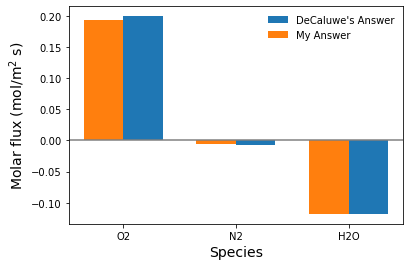

In [209]:
N_k_calc = pemfc_gas_transport(state1, state2, geom, gas_props)

from matplotlib import pyplot as plt
width = 0.35
N_k_check = np.array([0.19913, -0.007275, -0.11794]) #mol/m2/s

fig, ax = plt.subplots()

labels = ['O2', 'N2', 'H2O']
x = np.arange(len(labels))

ax.bar(x+width/2,N_k_check,width)
ax.bar(x-width/2,N_k_calc,width)
ax.legend(['DeCaluwe\'s Answer','My Answer'],frameon=False)

ax.set_xticks(x)
ax.set_xticklabels(labels)

#add line at y=0 for clarifying sign of D_N2
plt.axhline(y=0,color= 'grey')

#plot labels
ax.set_ylabel('Molar flux (mol/m$^2$ s)',fontsize=14)
ax.set_xlabel('Species',fontsize=14)

## Discussion
First off, I changed the y-label for this plot from 'Diffusion Coefficient' to 'Molar flux', since I think that was mislabeled. The units did not make sense on the plot, and this problem is asking us to calculate a function for N_k. Inspection of the plot commands also prove that this plot is plotting molar flux, not diffusion coefficients. The diffusion coefficients are not all that different between the 3 species, and are the same (positive) sign, whereas the molar fluxes do vary between the species.

With that out of the way, I notice that the molar flux of N2 is very low compared to that of H2O and O2. The molar flux of O2 is relatively large and positive, while the flux of H2O is negative is about half that of O2, and it is negative, meaning that the flux of H2O is moving from node 2 back to node 1. I think this can be explained by the fact that the major contribution to molar flux in this problem comes from diffusion. 

Convection, while present, is minimal (v_conv = 0.00167 m/s, for all species) whereas v_diff = [ 0.028, -0.002, -0.163], is much larger in magnitude. This diffusion is driven by concentration gradients that build up as O2 is consumed, and H2O is produced and the relative concentrations of these species are respectively decreased and increased at the catalyst. Nitrogen presumably does not participate in any chemical reaction (there is a slightly higher N2 concentration in the catalyst vs in the GDL, perhaps due to the pressure gradient), and hence its flux is very small in magnitude.

Finally, we assumed a very simple single node per phase model, but assuming a vertical fuel cell orientation, it might be interesting to look at molar flux as a function of vertical position. I imagine that bubbles form at the GDL/catalyst interface (and float up), so the interfacial area available might be reduced where the bubbles coalesce. This is just an idea.

## Part II: Charged species transport in a liquid electrolyte:

Next we will calculate molar fluxes for a liquid electrolyte in a battery anode.  These calculations will be for electro-diffusion only - there is no convection!

The molar density of the electrolyte is assumed constant at 1100 moles per m$^3$

The temperature is 45$^\circ$C.

The electrolyte is LiPF$_6$, dissolved in a generic "solvent" molecule, with the following conditions:

1. Node 1:
- $X_{\rm Li^+} = 0.03$
- $X_{\rm PF^-_6} = 0.03$
- $X_{\rm Solvent} = 0.94$
- Electric potential $\phi_1 = 0.9$ V

2. Node 2:
- $X_{\rm Li^+} = 0.06$
- $X_{\rm PF^-_6} = 0.06$
- $X_{\rm Solvent} = 0.88$
- Electric potential $\phi_2 = 0.5$ V

The distance between the nodes is 30 microns, and the average diameter of the solid active material particles is 5 microns.  The anode porosity (electrolyte volume fraction) is 23%, and the tortuosity is characterized by a Bruggeman coefficient of -0.5.

In [132]:
C_elyte = 1100 #mol/m3

# Species order: Li+, PF6-, solvent
X_k_1 = np.array([0.03, 0.03, 0.94])
X_k_2 = np.array([0.06, 0.06, 0.88])

z_k = np.array([1., -1., 0.])

T = 318.  #K

dY = 30e-6 #meters

#diffusion coefficients
D_k = np.array([1.52e-10, 0.25e-10, 1e-12])

#electric potentials
phi_1 = 0.9
phi_2 = 0.5

#active material particle diameter
d_part = 5e-6

#porosity
eps_elyte = 0.23

#tortuosity
n_brugg = -0.5

#Faraday's constant
F = 96485.332       #C/equiv

## ENTER CODE HERE 

### to Create the Necessary Dictionaries. We will call the states just 's1' and 's2', this time:

In [133]:
# State variables for node 1:
s1 = {'X_k':X_k_1, 'T':T, 'phi':phi_1, 'C_k':X_k_1*C_elyte}
# State variables for node 2:
s2 = {'X_k':X_k_2, 'T':T, 'phi':phi_2, 'C_k':X_k_2*C_elyte}

#interface concentrations
C_k_int = (s1['C_k']+s2['C_k'])/2

# Geometric and microstructure parameters:
geom = {'eps_elyte':eps_elyte, 'n_Brugg':n_Brugg, 'd_part':d_part, 'dY':dY}

# Electrolyte properties
elyte_pars = {'D_k':D_k, 'z_k':z_k, 'C_elyte':C_elyte}

## NOW CREATE YOUR FLUX-CALCULATING FUNCTION:

In [211]:
def electrolyte_transport(state1, state2, geom, elyte_pars):
    N_k = np.zeros_like(s1['X_k'])
    #gradC = (s2['C_k']-s1['C_k'])/geom['dY']
    gradX_k = (s2['X_k']-s1['X_k'])/geom['dY']
    gradPhi = (s2['phi'] - s1['phi'])/geom['dY']
    D_k_eff = geom['eps_elyte']**1.5*elyte_pars['D_k']
    D_k_mig = D_k_eff*C_k_int*elyte_pars['z_k']*F/R/T
    X_k_int = (s1['X_k']+s2['X_k'])/2
    N_k = -D_k_eff*gradX_k*C_k_int/X_k_int-D_k_mig*gradPhi
    return N_k



Now we loop over a range of Node 2 electric potentials.  We use the fluxes to calculate the current density:
\begin{equation}
i = F\sum_k z_kN_k
\end{equation}

In [212]:
dPhi = np.linspace(0,1.1,25)
currents = np.zeros_like(dPhi)
N_k = np.zeros((len(dPhi), len(z_k)))


for j, phi in enumerate(dPhi):
    s2['phi'] = phi
    N_k[j,:] = electrolyte_transport(s1,s2, geom, elyte_pars)
    currents[j] = np.dot(z_k,N_k[j,:])*F


## Plot the currents and check them against mine.
(You do not need to enter anything)
### For what potential is the current equal to zero?

Zero current at dPhi =  0.8868918573910756


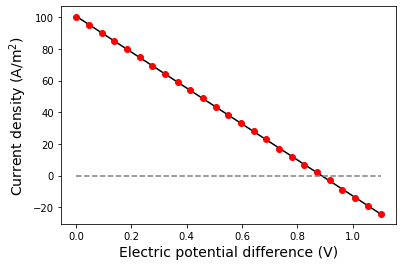

In [136]:
current_check = np.array([100.,  95.,  90.,  85.,  80.,  75.,  69.,
                          64.,  59.,  54.,  49.,  43.,  38.,  33.,
                          28.,  23.,  17.,  12.,   7.,   2.,  -3.,
                          -9.,    -14., -19., -24.])

plt.plot(dPhi, currents, 'k')
plt.plot(dPhi, current_check, 'ro', markerfacecolor=None)
plt.plot(dPhi, np.zeros_like(dPhi),'--',color='0.5')
plt.xlabel('Electric potential difference (V)',fontsize=14)
plt.ylabel('Current density (A/m$^2$)',fontsize=14)

zero=np.interp(0, np.flip(currents), np.flip(dPhi))
print('Zero current at dPhi = ',zero)

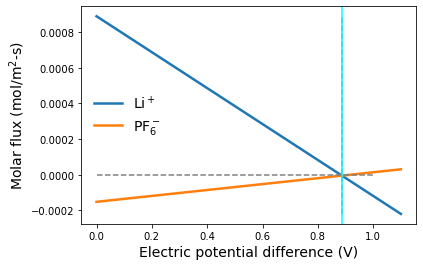

In [137]:
plt.plot(dPhi, N_k[:,0],linewidth=2.5)
plt.plot(dPhi, N_k[:,1],linewidth=2.5)

plt.xlabel('Electric potential difference (V)',fontsize=14)
plt.ylabel('Molar flux (mol/m$^2$-s)',fontsize=14)
plt.legend(['Li$^+$','PF$_6^-$'],frameon=False,fontsize=14)
plt.plot([zero,zero],[N_k[-1,0],N_k[0,0]],'--',color='0.5')
plt.axvline(0.8868918573910756, color = 'cyan')
plt.plot([0,1],[0,0],'--',color='0.5')

## Discuss the plot above in this Markdown block.  When is zero ionic current achieved?

Zero current is achieved when the products z_Li * N_Li and z_PF6 * N_PF6 sum to zero, which occurs when the molar flux of Li+ is equal to PF6- since their charges are equal but opposite in sign. This condition is met at dphi = 0.8868918573910756 V (~0.89 V, plotted above in cyan), which is the same answer as we saw in the previous plot where we graphed dphi vs current density.

This makes sense, because the current flow in this system is a result of ionic transport at the electrolyte/anode interface (the electrolyte should not conduct electrons). Indeed, observation of input block where the function "currents[j]" is defined, shows that "currents" is simply taking the dot product of z_k and N_k over various values of dphi.





### Now predict current as a function of electrolyte volume fraction $\varepsilon_{\rm elyte}$

(You do not need to type anything)

Text(0, 0.5, 'Current Density (A/m$^2$)')

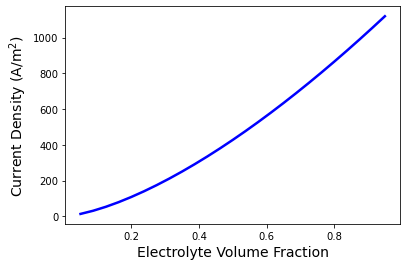

In [215]:
eps_array = np.linspace(0.05,.95,25)

currents = np.zeros_like(eps_array)
for j, eps in enumerate(eps_array):
    geom['eps_elyte'] = eps
    N_k = electrolyte_transport(s1, s2, geom, elyte_pars)
    currents[j] = np.dot(elyte_pars['z_k'],N_k)*F    
plt.plot(eps_array, currents,'b',linewidth=2.5)
plt.xlabel('Electrolyte Volume Fraction', fontsize=14)
plt.ylabel('Current Density (A/m$^2$)',fontsize=14)

### Discuss the results.  If you were designing a high-performance anode, what $\varepsilon_{\rm elyte}$ value would you pick?  Why?

 For a porous medium, the presence of a solid medium inhibits necessary ionic transport. However, charge transfer reactions take place at interfaces between the electrolyte and solid medium, so some solid material is required (and it is required to physically separate the electrodes to avoid short circuits). It seems from the plot (which demonstrates current density increasing continuously with electrolyte volume fraction) that the highest current density can be achieved with electrolyte volume fraction = 1, but I know that this can't be true, because that would mean that the electrolyte makes up 100% of the anode, and clearly that would not be good. 
 
 I think that a 50% porosity seems like a good tradeoff between interstitial reaction area and reduced tortuosity. With too high of porosity at the anode, one could imagine an extreme situation where there is so much electrolyte and very little anode for it to react with, and with too low porosity, there would conversely be plenty of anode but insufficient electrolyte and pathways for ions to flow and react. One thing I never considered before until now is how volume fraction is defined - what if optimal volume fraction was achieved, but each of the pores were dead end tunnels? Clearly, that would result in atrocious performance. I wonder if there is a way to assess the connectivity of the pores, since that seems to be very important for transport.

## Part III. Charged defects in a proton-conducting ceramic:

The protonic ceramic membrane in this section has a fixed crystal lattice that can be occupied by one of three species:

- An oxygen atom, O$^\times$ (this is considered the neutral species)
- A vacancy,V$_{\rm O}^{\bullet\bullet}$ which has a charge of +2, relative to the oxygen
- An oxygen atom with a proton attached, OH$^\bullet$

The lattice site concentration is assumed fixed at 22,325 mol per m$^3$.

The vacancy and proton are considered mobile, while the oxide is considered fixed.  We will simulate transport at 600$^\circ$C, where the diffusion coefficients are:

- $D_{\rm V_{\rm O}^{\bullet\bullet}} = 1.28\times 10^{-12}\,\frac{\rm m^2}{\rm s}$
- $D_{\rm O^\times} = 0.0\,\frac{\rm m^2}{\rm s}$
- $D_{\rm OH^\bullet} = 7.46\times 10^{-11}\,\frac{\rm m^2}{\rm s}$

The membrane also has a small amount of electronic conductivity, $\sigma_{\rm el} = 0.001\,\frac{\rm S}{\rm m}$.

We will simulate transport between two nodes, which are 20 microns apart.  The conditions are:

1. Node 1:
- $X_{\rm V_{\rm O}^{\bullet\bullet}} = 0.336$
- $X_{\rm O^\times} = 0.627$
- $X_{\rm OH^\bullet} = 0.037$
- $\phi_1 = 1.1$

2. Node 2:
- $X_{\rm V_{\rm O}^{\bullet\bullet}} = 0.018$
- $X_{\rm O^\times} = 0.938$
- $X_{\rm OH^\bullet} = 0.044$
- $\phi_2 = 0.0$

## Enter the data, here:

In [216]:
#lattice site concentration
C_latt = 22325 #mol/m3

# Species order: Oxygen vacanices, oxide, protonated O
X_k_1 = np.array([0.336, 0.627, 0.037])
X_k_2 = np.array([0.018, 0.938, 0.044])

#Diffusion coefficients 
D_k = np.array([1.28e-12, 0, 7.46e-11]) #[m^2/s]

#species charge
z_k = np.array([2., 0., 1.])

#temp
T = 873.  #K

#node separation
dY = 20e-6 #meters

#electric potentials [J/C]
phi_1 = 1.1
phi_2 = 0

#electrical conductivity [Siemens/m]
sigma = 0.001

#state variables
s1 = {'X_k':X_k_1, 'T':T, 'phi':phi_1, 'C_k':X_k_1*C_latt}

s2 = {'X_k':X_k_2, 'T':T, 'phi':phi_2, 'C_k':X_k_2*C_latt}

#interface species concentration & mole fraction
C_k_int = (s1['C_k']+s2['C_k'])/2
X_k_int = (s1['X_k']+s2['X_k'])/2

#gradient of mole fraction between nodes
grad_X_k = (s2['X_k']-s1['X_k'])/geom['dY']

#electrical potential gradient
grad_phi = (s2['phi']-s1['phi'])/geom['dY']

#ceramic membrane parameters
geom = {'dY':dY }
ceramic_pars = {'D_k':D_k, 'z_k':z_k, 'C_latt':C_latt, 'u_k': D_k/R/T,'t_k':t_k, 'sigma':sigma}

#conductivity
# diff_conduc = np.array[(R*T*sigma/ceramic_pars['z_k']/F/C_k_int, 0., R*T*sigma/ceramic_pars['z_k']/F/C_k_int)]
# conduc = {'diff':R*T*sigma/ceramic_pars['z_k']/F/C_k_int, 'elect':sigma}

#transference number
t_num = ceramic_pars['z_k']**2*ceramic_pars['u_k']*C_k_int
t_denom =sum(ceramic_pars['z_k']**2*ceramic_pars['u_k']*C_k_int)
t_k = t_num/t_denom



## CREATE YOUR TRANSPORT FUNCTION HERE.

This function should return the fluxes, N_k, and the total current (ionic + electronic).

In [217]:
def protonic_transport(s1, s2, geom, ceramic_pars):
    N_k = np.zeros_like(s1['X_k'])
    current = np.zeros_like(s1['X_k'])
    grad_phi = (s2['phi']-s1['phi'])/geom['dY']

#     N_k = -ceramic_pars['D_k']*C_k_int*grad_X_k/X_k_int-ceramic_pars['sigma']*ceramic_pars['t_k']*grad_phi/ceramic_pars['z_k']/F
    
    N_k = -ceramic_pars['D_k']*C_k_int*grad_X_k/X_k_int-ceramic_pars['D_k']*C_k_int*ceramic_pars['z_k']*F*grad_phi/R/T
#     problem = ceramic_pars['sigma']*ceramic_pars['t_k']*grad_phi/ceramic_pars['z_k']/F
    current = np.dot(ceramic_pars['z_k'],N_k)*F-grad_phi*ceramic_pars['sigma']
#     current = sum(ceramic_pars['z_k']*N_k)*F
#     print(current)
    return N_k, current


## Here, we loop over a range of electric potential diffrerences between node 1 and node 2.

You do not need to do anything; just run the cell.

We will plot both the total current and the Faradaic efficiency, as a function of $\Delta \phi$.  

The Faradaic efficiency $\eta_{\rm Far}$ refers to the fact that the electronic leakage current is "undesired," for the protonic fuel cell.  We want all current to move ions across the membrane.  Therefore we find the efficiency as:
\begin{equation}
    \eta_{\rm Far} = \frac{i_{\rm ion}}{i_{\rm total}}
\end{equation}

(99.0, 100.0)

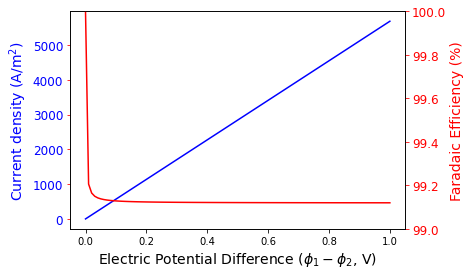

In [221]:
dPhi = np.linspace(0.0, 1.0, 100)
eta_Far = np.zeros_like(dPhi)
i_tot = np.zeros_like(dPhi)

for j, deltaPhi in enumerate(dPhi):
    s2['phi'] = s1['phi']-deltaPhi
    Nk, i_tot[j] = protonic_transport(s1, s2, geom, ceramic_pars)
    i_ion = np.dot(Nk,ceramic_pars['z_k'])*F
    
    eta_Far[j] = 100*i_ion/i_tot[j]
    
    
# Plot the results:
fig, ax = plt.subplots()
plt.plot(dPhi, i_tot,color='b')

# Create a 2nd y axis:
ax2 = ax.twinx()
ax2.plot(dPhi, eta_Far,'r')

# Formatting:
ax.set_xlabel('Electric Potential Difference ($\phi_1 - \phi_2$, V)', fontsize=14)

ax.tick_params(axis='y',color='r',labelcolor='b',labelsize=12)
ax.set_ylabel('Current density (A/m$^2$)',color='b',fontsize=14)
ax.tick_params(axis='y',color='r',labelcolor='b',labelsize=12)

ax2.set_ylabel('Faradaic Efficiency (%)',color='r',fontsize=14)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)
ax2.set_ylim((99,100))

## In this markdown cell, discuss the plot.  What explains the trends?


As the electrical potential difference increases, the protonic fuel cell must be "leaking" ions, decreasing the Faradaic efficiency. At dphi = 0, we are 100% faradic efficiency, I suppose because ionic current equal to the total current.

As soon as we introduce a potential difference, the Faradic efficiency drops lightly to about 99.1% and then flatlines. To be honest, I am confused in my interpretation of this plot. It would seem to me that in the direction we have chosen (node 1-->2 is positive direction), if we were to increase the electric potential of 1 relative to 2 (as we are doing in this plot as we move from the origin out along the x-axis) I would think that positive charged particles (protons in our case) would be driven to move to node 2, resulting in positive current. We do see this reflected by the increasing current density. Is the faradic efficiency decreasing because ions are moving out of the membrane? Isn't that what is desired?

### Now loop over a smaller range of potentials, to see where we get a net current of zero.

(you do not need to type anything; just run the cell).

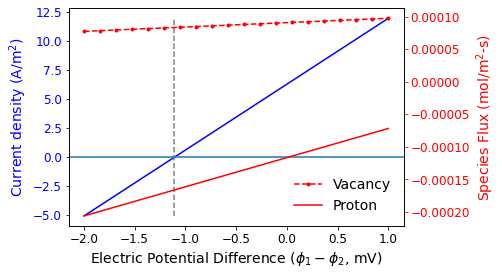

In [235]:
dPhi = np.linspace(-0.002, 0.001, 20)
N_k = np.zeros((len(dPhi),len(s1['X_k'])))
i_tot = np.zeros_like(dPhi)

for j, deltaPhi in enumerate(dPhi):
    s2['phi'] = s1['phi']-deltaPhi
    N_k[j,:], i_tot[j] = protonic_transport(s1, s2, geom, ceramic_pars)

fig, ax = plt.subplots()
plt.plot(1000*dPhi, i_tot,color='b')

zero = 1000*np.interp(0,i_tot,dPhi)
plt.plot([zero,zero],[i_tot[0],i_tot[-1]],'--',color='0.5')

ax.set_ylabel('Current density (A/m$^2$)',color='b',fontsize=14)
ax.tick_params(axis='y',color='k',labelcolor='b',labelsize=12)
ax.tick_params(axis='y',color='k',labelcolor='b',labelsize=12)

ax.tick_params(axis='x',color='k',labelcolor='k',labelsize=12)
ax.set_xlabel('Electric Potential Difference ($\phi_1 - \phi_2$, mV)', fontsize=14)
# ax.set_xlim((-0.01,0.01))

#add a horizontal line at y =0
plt.axhline(y=0)

ax2 = ax.twinx()
ax2.plot(1000*dPhi, N_k[:,0],'r.--')
ax2.plot(1000*dPhi, N_k[:,2],color='r')

ax2.set_ylabel('Species Flux (mol/m$^2$-s)',color='r',fontsize=14)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)

ax2.legend(['Vacancy','Proton'],fontsize=14,frameon=False)



### Discuss the result.  Is the 'zero current' condition the same as for the battery anode?  

What about your model equations explains the trends?

The 'zero current' condition is just under -1 mV, which is orders of magnitude lower than the zero current condition for the battery anode (~0.9V). My model equation that explains this trend is the current equation, which includes an ohmic contribution (protons are conducted through the membrane) in addition to the electrochemical contributions to current.
